In [2]:
!pip install advertorch

     ---------------------------------------- 5.7/5.7 MB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for advertorch: filename=advertorch-0.2.3-py3-none-any.whl size=5696204 sha256=6e93792b0fdb2192078fab34fab2cd853d37b656f50de7714ae52103915645ca
  Stored in directory: c:\users\anass\appdata\local\pip\cache\wheels\1b\00\de\d11c024ea240dfcf62cd3a94e1653bbb26139777243701dbf5
Successfully built advertorch


In [3]:
!pip install ipdb

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from advertorch.attacks import LinfPGDAttack, L2PGDAttack, DDNL2Attack
import ipdb

In [19]:
def zero_gradients(x):
    if isinstance(x, torch.Tensor):
        if x.grad is not None:
            x.grad.detach_()
            x.grad.zero_()
    elif isinstance(x, collections.abc.Iterable):
        for elem in x:
            zero_gradients(elem)

In [20]:
input_shape = (17, 17)

In [21]:
class SmallCNN(nn.Module):
    def __init__(self, activation=F.relu):
        super(SmallCNN, self).__init__()
        self.in_normalize = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 512, 17, padding=8, padding_mode='circular')
        self.activation = activation
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = self.in_normalize(x)
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 512*1)
        x = self.fc2(x)
        return x

class SmallCNN_no_padding(nn.Module):
    def __init__(self, activation=F.relu):
        super(SmallCNN_no_padding, self).__init__()
        self.in_normalize = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 512, 17) # padding=8, padding_mode='circular')
        self.activation = activation
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.in_normalize(x)
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 512*1)
        x = self.fc2(x)
        return x

class FCNN(nn.Module):
    def __init__(self, activation=F.relu):
        super(FCNN, self).__init__()
        self.in_normalize = nn.BatchNorm2d(1)
        self.fc1 = nn.Linear(input_shape[0]*input_shape[1], 512)
        self.activation = activation
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = self.in_normalize(x)
        x = x.view(-1, input_shape[0]*input_shape[1])
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
im_1 = np.zeros(input_shape)+0.5
im_2 = im_1.copy()
im_1[7][7]+=0.5
im_2[7][7]-=0.5

In [23]:
np.stack([im_1, im_2]).shape

(2, 17, 17)

In [24]:
# im_1 = im_1.
data = np.stack([np.expand_dims(im_1, axis=0), np.expand_dims(im_2, axis=0)], axis=0)
y = np.array([1, 0])
batch_X, batch_y = torch.tensor(data).float().cuda(), torch.tensor(y).long().cuda()
criterion = nn.CrossEntropyLoss()
model_cnn = SmallCNN()
model_cnn = model_cnn.cuda()
LR = 0.01
opt = torch.optim.SGD(model_cnn.parameters(), lr = LR)


for idx in range(2000):
    total_loss = 0
    total_acc = 0
    output = model_cnn(batch_X)
    loss = criterion(output, batch_y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss*batch_y.size(0)
    total_acc += (output.max(1)[1] == batch_y).sum().item()
    if (idx+1) % 800==0:
        opt.param_groups[0].update(lr=LR/10)
    if (idx+1)%100==0:
        print("Epoch: {}, Train Acc: {:.3f}, Loss : {:.3f}".format(idx+1, total_acc*100./y.shape[0], total_loss/y.shape[0]))



Epoch: 100, Train Acc: 100.000, Loss : 0.579
Epoch: 200, Train Acc: 100.000, Loss : 0.422
Epoch: 300, Train Acc: 100.000, Loss : 0.239
Epoch: 400, Train Acc: 100.000, Loss : 0.119
Epoch: 500, Train Acc: 100.000, Loss : 0.064
Epoch: 600, Train Acc: 100.000, Loss : 0.039
Epoch: 700, Train Acc: 100.000, Loss : 0.027
Epoch: 800, Train Acc: 100.000, Loss : 0.020
Epoch: 900, Train Acc: 100.000, Loss : 0.019
Epoch: 1000, Train Acc: 100.000, Loss : 0.018
Epoch: 1100, Train Acc: 100.000, Loss : 0.018
Epoch: 1200, Train Acc: 100.000, Loss : 0.017
Epoch: 1300, Train Acc: 100.000, Loss : 0.017
Epoch: 1400, Train Acc: 100.000, Loss : 0.017
Epoch: 1500, Train Acc: 100.000, Loss : 0.016
Epoch: 1600, Train Acc: 100.000, Loss : 0.016
Epoch: 1700, Train Acc: 100.000, Loss : 0.015
Epoch: 1800, Train Acc: 100.000, Loss : 0.015
Epoch: 1900, Train Acc: 100.000, Loss : 0.015
Epoch: 2000, Train Acc: 100.000, Loss : 0.014


In [25]:
data = np.stack([np.expand_dims(im_1, axis=0), np.expand_dims(im_2, axis=0)], axis=0)
y = np.array([1, 0])
batch_X, batch_y = torch.tensor(data).float().cuda(), torch.tensor(y).long().cuda()
criterion = nn.CrossEntropyLoss()

model_cnn_np = SmallCNN_no_padding()
model_cnn_np = model_cnn_np.cuda()

LR = 0.01
opt = torch.optim.SGD(model_cnn_np.parameters(), lr = LR)


for idx in range(2000):
    total_loss = 0
    total_acc = 0
    output = model_cnn_np(batch_X)
    loss = criterion(output, batch_y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss*batch_y.size(0)
    total_acc += (output.max(1)[1] == batch_y).sum().item()
    if (idx+1) % 800==0:
        opt.param_groups[0].update(lr=LR/10)
    if (idx+1)%100==0:
        print("Epoch: {}, Train Acc: {:.3f}, Loss : {:.3f}".format(idx+1, total_acc*100./y.shape[0], total_loss/y.shape[0]))

Epoch: 100, Train Acc: 100.000, Loss : 0.005
Epoch: 200, Train Acc: 100.000, Loss : 0.002
Epoch: 300, Train Acc: 100.000, Loss : 0.001
Epoch: 400, Train Acc: 100.000, Loss : 0.001
Epoch: 500, Train Acc: 100.000, Loss : 0.001
Epoch: 600, Train Acc: 100.000, Loss : 0.001
Epoch: 700, Train Acc: 100.000, Loss : 0.001
Epoch: 800, Train Acc: 100.000, Loss : 0.000
Epoch: 900, Train Acc: 100.000, Loss : 0.000
Epoch: 1000, Train Acc: 100.000, Loss : 0.000
Epoch: 1100, Train Acc: 100.000, Loss : 0.000
Epoch: 1200, Train Acc: 100.000, Loss : 0.000
Epoch: 1300, Train Acc: 100.000, Loss : 0.000
Epoch: 1400, Train Acc: 100.000, Loss : 0.000
Epoch: 1500, Train Acc: 100.000, Loss : 0.000
Epoch: 1600, Train Acc: 100.000, Loss : 0.000
Epoch: 1700, Train Acc: 100.000, Loss : 0.000
Epoch: 1800, Train Acc: 100.000, Loss : 0.000
Epoch: 1900, Train Acc: 100.000, Loss : 0.000
Epoch: 2000, Train Acc: 100.000, Loss : 0.000


In [26]:
data = np.stack([np.expand_dims(im_1, axis=0), np.expand_dims(im_2, axis=0)], axis=0)
y = np.array([1, 0])
batch_X, batch_y = torch.tensor(data).float().cuda(), torch.tensor(y).long().cuda()
criterion = nn.CrossEntropyLoss()

model_fc = FCNN()
model_fc = model_fc.cuda()


LR = 0.01
opt = torch.optim.SGD(model_fc.parameters(), lr = LR)


for idx in range(2000):
    total_loss = 0
    total_acc = 0
    output = model_fc(batch_X)
    loss = criterion(output, batch_y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss*batch_y.size(0)
    total_acc += (output.max(1)[1] == batch_y).sum().item()
    if (idx+1) % 800==0:
        opt.param_groups[0].update(lr=LR/10)
    if (idx+1)%100==0:
        print("Epoch: {}, Train Acc: {:.3f}, Loss : {:.3f}".format(idx+1, total_acc*100./y.shape[0], total_loss/y.shape[0]))

Epoch: 100, Train Acc: 100.000, Loss : 0.005
Epoch: 200, Train Acc: 100.000, Loss : 0.002
Epoch: 300, Train Acc: 100.000, Loss : 0.001
Epoch: 400, Train Acc: 100.000, Loss : 0.001
Epoch: 500, Train Acc: 100.000, Loss : 0.001
Epoch: 600, Train Acc: 100.000, Loss : 0.001
Epoch: 700, Train Acc: 100.000, Loss : 0.001
Epoch: 800, Train Acc: 100.000, Loss : 0.000
Epoch: 900, Train Acc: 100.000, Loss : 0.000
Epoch: 1000, Train Acc: 100.000, Loss : 0.000
Epoch: 1100, Train Acc: 100.000, Loss : 0.000
Epoch: 1200, Train Acc: 100.000, Loss : 0.000
Epoch: 1300, Train Acc: 100.000, Loss : 0.000
Epoch: 1400, Train Acc: 100.000, Loss : 0.000
Epoch: 1500, Train Acc: 100.000, Loss : 0.000
Epoch: 1600, Train Acc: 100.000, Loss : 0.000
Epoch: 1700, Train Acc: 100.000, Loss : 0.000
Epoch: 1800, Train Acc: 100.000, Loss : 0.000
Epoch: 1900, Train Acc: 100.000, Loss : 0.000
Epoch: 2000, Train Acc: 100.000, Loss : 0.000


In [27]:
model_cnn

SmallCNN(
  (in_normalize): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 512, kernel_size=(17, 17), stride=(1, 1), padding=(8, 8), padding_mode=circular)
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [28]:
model_cnn_np

SmallCNN_no_padding(
  (in_normalize): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 512, kernel_size=(17, 17), stride=(1, 1))
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [29]:
model_fc

FCNN(
  (in_normalize): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=289, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [30]:
model_cnn = model_cnn.eval()
model_fc = model_fc.eval()
model_cnn_np = model_cnn_np.eval()

In [31]:
model_cnn = model_cnn.to('cuda')

In [32]:
model_fc = model_fc.to('cuda')

In [33]:
model_cnn_np = model_cnn_np.to('cuda')

In [52]:
def test_pgd(model,X, y, adversary, batch_size):
    SPLITS = int(X.shape[0]/batch_size)
    total_acc = 0
    for idx in range(SPLITS):
        s1, s2 = idx*batch_size, min((idx+1)*batch_size, X.shape[0])
#         ipdb.set_trace()
        batch_X, batch_y = X[s1:s2,:,:,:], y[s1:s2]
        batch_X, batch_y = torch.tensor(batch_X).float().cuda(), torch.tensor(batch_y).long().cuda()
#         ipdb.set_trace()
        adv_untargeted = adversary.perturb(batch_X, batch_y)
        robust_out = model(adv_untargeted)
        total_acc += (robust_out.max(1)[1] == batch_y).sum().item()
        
#     print("Test Robust Acc: {:.3f}".format(total_acc*100./y.shape[0]))
    return total_acc*100./y.shape[0]

def test_pgd_ddn(model,X, y, adversary, batch_size):
    SPLITS = int(X.shape[0]/batch_size)
    total_acc = 0
    for idx in range(SPLITS):
        s1, s2 = idx*batch_size, min((idx+1)*batch_size, X.shape[0])
#         ipdb.set_trace()
        batch_X, batch_y = X[s1:s2,:,:,:], y[s1:s2]
        batch_X, batch_y = torch.tensor(batch_X).float().cuda(), torch.tensor(batch_y).long().cuda()
#         ipdb.set_trace()
        adv_untargeted = adversary.perturb(batch_X, batch_y)
        robust_out = model(adv_untargeted)
        total_acc += (robust_out.max(1)[1] == batch_y).sum().item()
        
#     print("Test Robust Acc: {:.3f}".format(total_acc*100./y.shape[0]))
    return total_acc*100./y.shape[0], adv_untargeted

def l2_norms_diff(x, y):
    x = x.reshape(x.shape[0], -1).cpu().numpy()
    y = y.reshape(y.shape[0], -1)
    norms = np.linalg.norm(x-y, ord=2, axis=1)
    return norms, norms.mean(), np.median(norms)

In [53]:
range_input = (data.max() - data.min())

adversary = DDNL2Attack(model_cnn, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
                nb_iter=1000, clip_min=data.min(), clip_max=data.max(), quantize=False,
                targeted=False)
robust_acc_cnn, adv_data_cnn = test_pgd_ddn(model_cnn, data, y, adversary, 2)
# print("Epsilon : {}, Robust Accuracy: {}".format(eps, robust_acc))
norms, mean_norm, median_norm = l2_norms_diff(adv_data_cnn, data)
print("CNN Mean Norm: {}".format(mean_norm))
print("CNN accuracy on adv data: {}".format(robust_acc_cnn))

adversary = DDNL2Attack(model_cnn_np, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
                nb_iter=1000, clip_min=data.min(), clip_max=data.max(), quantize=False,
                targeted=False)
robust_acc_cnn_np, adv_data_cnn_np = test_pgd_ddn(model_cnn_np, data, y, adversary, 2)
# print("Epsilon : {}, Robust Accuracy: {}".format(eps, robust_acc))
norms, mean_norm, median_norm = l2_norms_diff(adv_data_cnn_np, data)
print("CNN no padding Mean Norm: {}".format(mean_norm))
print("CNN no padding accuracy on adv data: {}".format(robust_acc_cnn_np))

adversary = DDNL2Attack(model_fc, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
                        nb_iter=1000, clip_min=data.min(), clip_max=data.max(), quantize=False,
                        targeted=False)
robust_acc_fc, adv_data_fc = test_pgd_ddn(model_fc, data, y, adversary, 2)
# print("Epsilon : {}, Robust Accuracy: {}".format(eps, robust_acc))
norms, mean_norm, median_norm = l2_norms_diff(adv_data_fc, data)
print("FC Mean Norm: {}".format(mean_norm))
print("FC accuracy on adv data: {}".format(robust_acc_fc))

C:\Users\anass\anaconda3\envs\handson-ml3\lib\site-packages\advertorch\attacks\decoupled_direction_norm.py:48: UserWarning: This Attack currently does not support a different loss function other than the default. Setting loss_fn manually is not effective.
  warnings.warn(
C:\Users\anass\anaconda3\envs\handson-ml3\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


CNN Mean Norm: 0.02946768221805582
CNN accuracy on adv data: 0.0
CNN no padding Mean Norm: 0.3431688170411311
CNN no padding accuracy on adv data: 0.0
FC Mean Norm: 0.3360312926283041
FC accuracy on adv data: 0.0


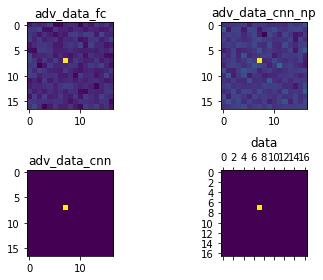

In [54]:
import matplotlib.pyplot as plt

# Create a figure and axes for the subplots
fig, axs = plt.subplots(2, 2)

# Plot the images
axs[0, 0].imshow(adv_data_fc.cpu().data.numpy()[0][0])
axs[0, 0].set_title('adv_data_fc')

axs[0, 1].imshow(adv_data_cnn_np.cpu().data.numpy()[0][0])
axs[0, 1].set_title('adv_data_cnn_np')

axs[1, 0].imshow(adv_data_cnn.cpu().data.numpy()[0][0])
axs[1, 0].set_title('adv_data_cnn')

axs[1, 1].matshow(data[0][0])
axs[1, 1].set_title('data')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [55]:
data.shape

(2, 1, 17, 17)

In [56]:
range_input = (data.max() - data.min())

for eps in [0.001, 0.002, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]:
    range_attack = range_input*eps
    step_attack = range_attack/50
    adversary = LinfPGDAttack(model_cnn, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=range_attack,
                    nb_iter=100, eps_iter=step_attack, rand_init=True, clip_min=data.min(), clip_max=data.max(),
                    targeted=False)
    robust_acc = test_pgd( model_cnn,data, y, adversary, 2)
    print("Epsilon : {}, Robust Accuracy: {}".format(eps, robust_acc))

Epsilon : 0.001, Robust Accuracy: 100.0
Epsilon : 0.002, Robust Accuracy: 0.0
Epsilon : 0.005, Robust Accuracy: 0.0
Epsilon : 0.01, Robust Accuracy: 0.0
Epsilon : 0.02, Robust Accuracy: 0.0
Epsilon : 0.03, Robust Accuracy: 0.0
Epsilon : 0.04, Robust Accuracy: 0.0
Epsilon : 0.05, Robust Accuracy: 0.0


In [57]:
range_input = (data.max() - data.min())

for eps in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]:
    range_attack = range_input*eps
    step_attack = range_attack/50
    adversary = L2PGDAttack(model_cnn, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=range_attack,
                    nb_iter=100, eps_iter=step_attack, rand_init=True, clip_min=data.min(), clip_max=data.max(),
                    targeted=False)
    robust_acc = test_pgd(model_cnn, data, y, adversary, 2)
    print("Epsilon : {}, Robust Accuracy: {}".format(eps, robust_acc))

Epsilon : 0.01, Robust Accuracy: 100.0
Epsilon : 0.02, Robust Accuracy: 100.0
Epsilon : 0.03, Robust Accuracy: 100.0
Epsilon : 0.04, Robust Accuracy: 0.0
Epsilon : 0.05, Robust Accuracy: 0.0
Epsilon : 0.06, Robust Accuracy: 0.0
Epsilon : 0.07, Robust Accuracy: 0.0
Epsilon : 0.08, Robust Accuracy: 0.0


In [58]:
range_input = (data.max() - data.min())

for eps in [0.001, 0.002, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]:
    range_attack = range_input*eps
    step_attack = range_attack/50
    adversary = LinfPGDAttack(model_fc, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=range_attack,
                              nb_iter=100, eps_iter=step_attack, rand_init=True, clip_min=data.min(), clip_max=data.max(),
                              targeted=False)
    robust_acc = test_pgd(model_fc,data, y, adversary, 2)
    print("Epsilon : {}, Robust Accuracy: {}".format(eps, robust_acc))

Epsilon : 0.001, Robust Accuracy: 100.0
Epsilon : 0.002, Robust Accuracy: 100.0
Epsilon : 0.005, Robust Accuracy: 100.0
Epsilon : 0.01, Robust Accuracy: 100.0
Epsilon : 0.02, Robust Accuracy: 100.0
Epsilon : 0.03, Robust Accuracy: 100.0
Epsilon : 0.04, Robust Accuracy: 0.0
Epsilon : 0.05, Robust Accuracy: 0.0


In [59]:
range_input = (data.max() - data.min())

for eps in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]:
    range_attack = range_input*eps
    step_attack = range_attack/50
    adversary = L2PGDAttack(model_fc, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=range_attack,
                            nb_iter=100, eps_iter=step_attack, rand_init=True, clip_min=data.min(), clip_max=data.max(),
                            targeted=False)
    robust_acc = test_pgd(model_fc,data, y, adversary, 2)
    print("Epsilon : {}, Robust Accuracy: {}".format(eps, robust_acc))

Epsilon : 0.01, Robust Accuracy: 100.0
Epsilon : 0.02, Robust Accuracy: 100.0
Epsilon : 0.03, Robust Accuracy: 100.0
Epsilon : 0.04, Robust Accuracy: 100.0
Epsilon : 0.05, Robust Accuracy: 100.0
Epsilon : 0.06, Robust Accuracy: 100.0
Epsilon : 0.07, Robust Accuracy: 100.0
Epsilon : 0.08, Robust Accuracy: 100.0


In [60]:
range_input = (data.max() - data.min())

for eps in [0.001, 0.002, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]:
    range_attack = range_input*eps
    step_attack = range_attack/50
    adversary = LinfPGDAttack(model_cnn_np, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=range_attack,
                              nb_iter=100, eps_iter=step_attack, rand_init=True, clip_min=data.min(), clip_max=data.max(),
                              targeted=False)
    robust_acc = test_pgd(model_cnn_np,data, y, adversary, 2)
    print("Epsilon : {}, Robust Accuracy: {}".format(eps, robust_acc))

Epsilon : 0.001, Robust Accuracy: 100.0
Epsilon : 0.002, Robust Accuracy: 100.0
Epsilon : 0.005, Robust Accuracy: 100.0
Epsilon : 0.01, Robust Accuracy: 100.0
Epsilon : 0.02, Robust Accuracy: 100.0
Epsilon : 0.03, Robust Accuracy: 100.0
Epsilon : 0.04, Robust Accuracy: 0.0
Epsilon : 0.05, Robust Accuracy: 0.0


In [63]:
range_input = (data.max() - data.min())

for eps in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]:
    range_attack = range_input*eps
    step_attack = range_attack/50
    adversary = L2PGDAttack(model_cnn_np, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=range_attack,
                            nb_iter=100, eps_iter=step_attack, rand_init=True, clip_min=data.min(), clip_max=data.max(),
                            targeted=False)
    robust_acc = test_pgd(model_cnn_np,data, y, adversary, 2)
    print("Epsilon : {}, Robust Accuracy: {}".format(eps, robust_acc))

Epsilon : 0.01, Robust Accuracy: 100.0
Epsilon : 0.02, Robust Accuracy: 100.0
Epsilon : 0.03, Robust Accuracy: 100.0
Epsilon : 0.04, Robust Accuracy: 100.0
Epsilon : 0.05, Robust Accuracy: 100.0
Epsilon : 0.06, Robust Accuracy: 100.0
Epsilon : 0.07, Robust Accuracy: 100.0
Epsilon : 0.08, Robust Accuracy: 100.0


CNN Model <br>
Epsilon : 0.001, Robust Accuracy: 100.0 <br>
Epsilon : 0.002, Robust Accuracy: 100.0 <br>
Epsilon : 0.005, Robust Accuracy: 0.0 <br>
Epsilon : 0.01, Robust Accuracy: 0.0 <br>
Epsilon : 0.02, Robust Accuracy: 0.0 <br>
Epsilon : 0.03, Robust Accuracy: 0.0 <br>
Epsilon : 0.04, Robust Accuracy: 0.0 <br>
Epsilon : 0.05, Robust Accuracy: 0.0 <br>

FC Model <br>
Epsilon : 0.001, Robust Accuracy: 100.0 <br>
Epsilon : 0.002, Robust Accuracy: 100.0 <br>
Epsilon : 0.005, Robust Accuracy: 100.0 <br>
Epsilon : 0.01, Robust Accuracy: 100.0 <br>
Epsilon : 0.02, Robust Accuracy: 100.0 <br>
Epsilon : 0.03, Robust Accuracy: 100.0 <br>
Epsilon : 0.04, Robust Accuracy: 100.0 <br>
Epsilon : 0.05, Robust Accuracy: 0.0 <br>

## PREVIOUS EXPERIMENTS DISCARDDD

FC Model <br>
Epsilon : 0.01, Robust Accuracy: 100.0 <br>
Epsilon : 0.02, Robust Accuracy: 100.0 <br>
Epsilon : 0.03, Robust Accuracy: 100.0 <br>
Epsilon : 0.04, Robust Accuracy: 100.0 <br>
Epsilon : 0.05, Robust Accuracy: 100.0 <br>
Epsilon : 0.06, Robust Accuracy: 50.0 <br>
Epsilon : 0.07, Robust Accuracy: 100.0 <br>
Epsilon : 0.08, Robust Accuracy: 100.0 <br>
Epsilon : 0.09, Robust Accuracy: 0.0 <br>
Epsilon : 0.1, Robust Accuracy: 100.0 <br>
<br>
CNN Model <br>
Epsilon : 0.01, Robust Accuracy: 0.0 <br>
Epsilon : 0.02, Robust Accuracy: 0.0 <br>
Epsilon : 0.03, Robust Accuracy: 0.0 <br>
Epsilon : 0.04, Robust Accuracy: 0.0 <br>
Epsilon : 0.05, Robust Accuracy: 0.0 <br>
Epsilon : 0.06, Robust Accuracy: 0.0 <br>
Epsilon : 0.07, Robust Accuracy: 0.0 <br>
Epsilon : 0.08, Robust Accuracy: 0.0 <br>
Epsilon : 0.09, Robust Accuracy: 0.0 <br>
Epsilon : 0.1, Robust Accuracy: 0.0 <br>

In [27]:
range_input = np.linalg.norm(data.reshape((data.shape[0], -1)), ord=2, axis=1).mean()

for eps in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    range_attack = range_input*eps
    step_attack = range_attack/10
    adversary = L2PGDAttack(model_cnn, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=range_attack,
                    nb_iter=50, eps_iter=step_attack, rand_init=True, clip_min=data.min(), clip_max=data.max(),
                    targeted=False)
    robust_acc = test_pgd(data, y, adversary, 2)
    print("Epsilon : {}, Robust Accuracy: {}".format(eps, robust_acc))

Epsilon : 0.2, Robust Accuracy: 100.0
Epsilon : 0.3, Robust Accuracy: 100.0
Epsilon : 0.4, Robust Accuracy: 100.0
Epsilon : 0.5, Robust Accuracy: 50.0
Epsilon : 0.6, Robust Accuracy: 0.0
Epsilon : 0.7, Robust Accuracy: 0.0
Epsilon : 0.8, Robust Accuracy: 0.0
